In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import cv2
import random
import shutil
from collections import defaultdict
from tqdm import tqdm

# Your dataset paths
image_dir = '/kaggle/input/fruit-yield/FruitYield DataSet/Fruit_Annotation_Object_Det-14/train/images'
label_dir = '/kaggle/input/fruit-yield/FruitYield DataSet/Fruit_Annotation_Object_Det-14/train/labels'
aug_image_dir = '/kaggle/working/augmented_dataset/images'
aug_label_dir = '/kaggle/working/augmented_dataset/labels'

# Create output dirs
os.makedirs(aug_image_dir, exist_ok=True)
os.makedirs(aug_label_dir, exist_ok=True)

# Count how many images contain each class
image_class_map = defaultdict(set)

for label_file in os.listdir(label_dir):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id = int(line.strip().split()[0])
                image_name = label_file.replace(".txt", ".jpg")
                image_class_map[class_id].add(image_name)

image_count_per_class = {cls: len(images) for cls, images in image_class_map.items()}
target_count = max(image_count_per_class.values())

print("🔢 Original class counts (by image presence):")
for k, v in image_count_per_class.items():
    print(f"Class {k}: {v}")
print(f"🎯 Target count per class: {target_count}\n")

# Augment
augmentation_id = 0
for class_id, images in image_class_map.items():
    needed = target_count - len(images)
    if needed <= 0:
        continue

    print(f"Augmenting class {class_id} with {needed} images...")
    images = list(images)
    for _ in tqdm(range(needed)):
        original_image = random.choice(images)
        img_path = os.path.join(image_dir, original_image)
        label_path = os.path.join(label_dir, original_image.replace(".jpg", ".txt"))

        # Load image and label
        img = cv2.imread(img_path)
        with open(label_path, 'r') as f:
            label_data = f.read()

        # Choose augmentation
        if random.random() < 0.5:
            img = cv2.flip(img, 1)  # Horizontal flip
        else:
            value = random.uniform(0.5, 1.5)
            img = cv2.convertScaleAbs(img, alpha=value, beta=0)

        aug_img_name = f"aug_{augmentation_id}.jpg"
        aug_lbl_name = f"aug_{augmentation_id}.txt"

        cv2.imwrite(os.path.join(aug_image_dir, aug_img_name), img)
        with open(os.path.join(aug_label_dir, aug_lbl_name), 'w') as f:
            f.write(label_data)

        augmentation_id += 1

# Optionally copy original data too
for f in os.listdir(image_dir):
    shutil.copy(os.path.join(image_dir, f), os.path.join(aug_image_dir, f))
for f in os.listdir(label_dir):
    shutil.copy(os.path.join(label_dir, f), os.path.join(aug_label_dir, f))

print("✅ Augmentation complete and combined with original dataset.")

In [1]:
import os

# Path to your final image directory (includes both original + augmented images)
augmented_image_dir = '/kaggle/working/augmented_dataset/images'

# Get list of image files
image_files = [f for f in os.listdir(augmented_image_dir) if f.endswith('.jpg')]

# Count
total_images = len(image_files)

print(f"🖼️ Total number of images in augmented dataset: {total_images}")


🖼️ Total number of images in augmented dataset: 2358


In [2]:
import os

# Path to your final image directory (includes both original + augmented images)
augmented_image_dir = '/kaggle/input/fruit-yield/FruitYield DataSet/Fruit_Annotation_Object_Det-14/train/images'

# Get list of image files
image_files = [f for f in os.listdir(augmented_image_dir) if f.endswith('.jpg')]

# Count
total_images = len(image_files)

print(f"🖼️ Total number of images in augmented dataset: {total_images}")


🖼️ Total number of images in augmented dataset: 2192


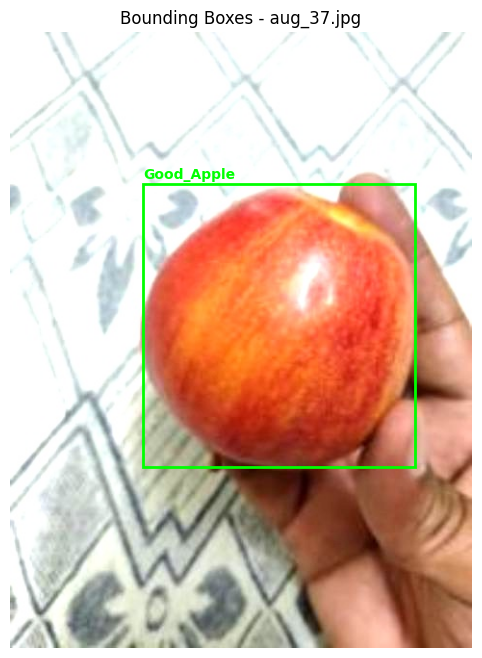

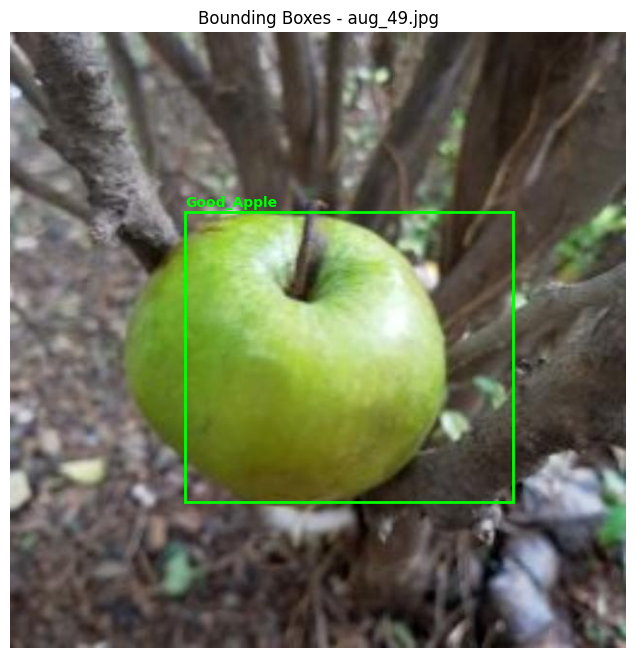

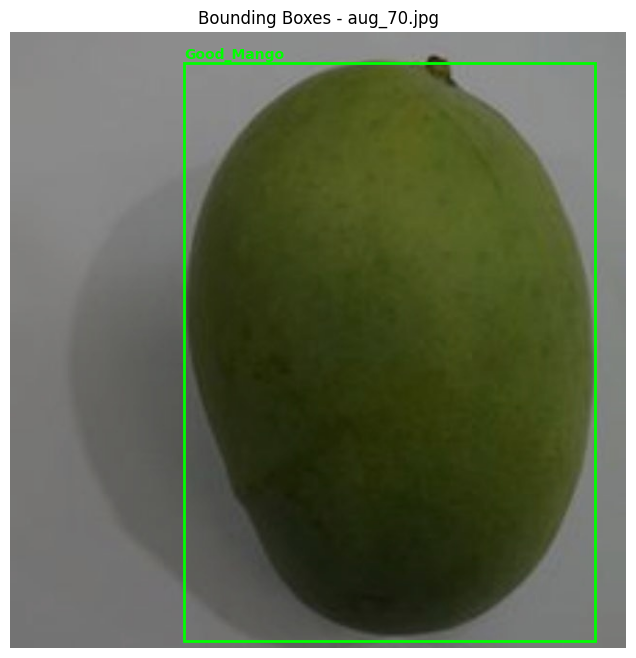

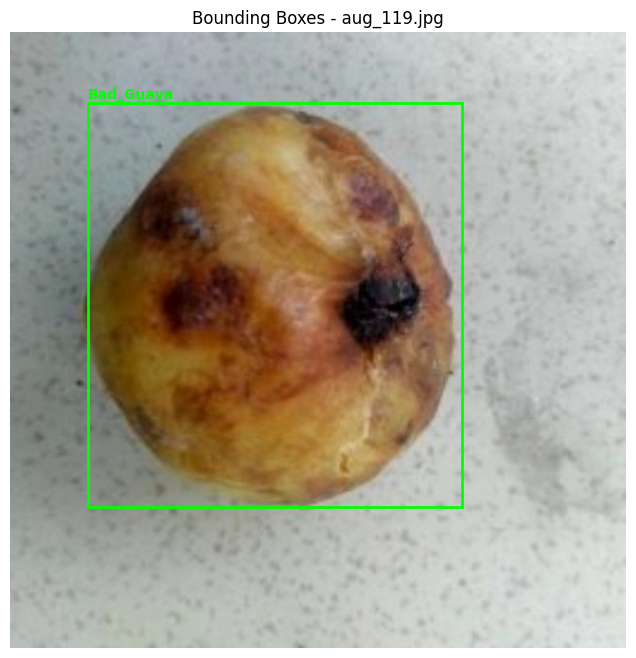

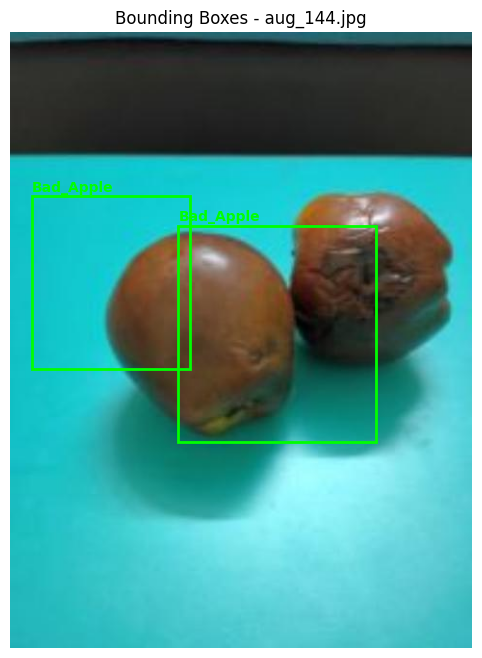

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Paths to your augmented data
aug_image_dir = '/kaggle/working/augmented_dataset/images'
aug_label_dir = '/kaggle/working/augmented_dataset/labels'

# Your class names (index must match class ID)
class_names = [
    'Bad_Apple',
    'Bad_Guava',
    'Bad_Mango',
    'Bad_Orange',
    'Good_Apple',
    'Good_Guava',
    'Good_Mango',
    'Good_Orange'
]

# Get a list of augmented images only
aug_images = [f for f in os.listdir(aug_image_dir) if f.startswith('aug_') and f.endswith('.jpg')]

# How many to visualize
num_images_to_plot = 5

for image_file in aug_images[:num_images_to_plot]:
    image_path = os.path.join(aug_image_dir, image_file)
    label_path = os.path.join(aug_label_dir, image_file.replace('.jpg', '.txt'))

    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # Plot image
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Read and draw bounding boxes
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            class_id, x_center, y_center, box_width, box_height = map(float, line.strip().split())

            # Convert from YOLO to pixel coordinates
            x_center *= w
            y_center *= h
            box_width *= w
            box_height *= h

            x_min = x_center - box_width / 2
            y_min = y_center - box_height / 2

            # Draw box
            rect = patches.Rectangle((x_min, y_min), box_width, box_height,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

            # Draw label (class name)
            class_name = class_names[int(class_id)]
            ax.text(x_min, y_min - 5, class_name, color='lime', fontsize=10, weight='bold')
    
    ax.set_title(f"Bounding Boxes - {image_file}")
    ax.axis('off')
    plt.show()


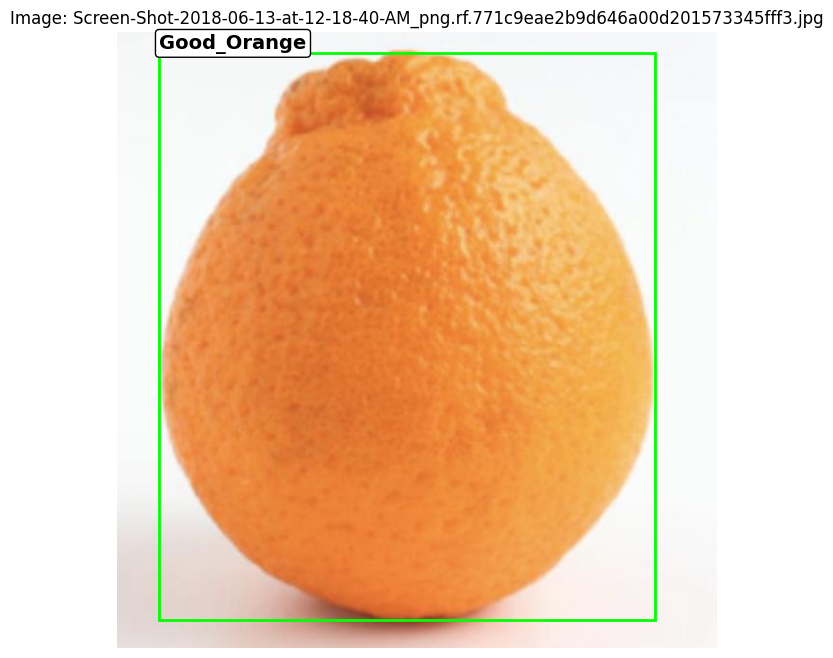

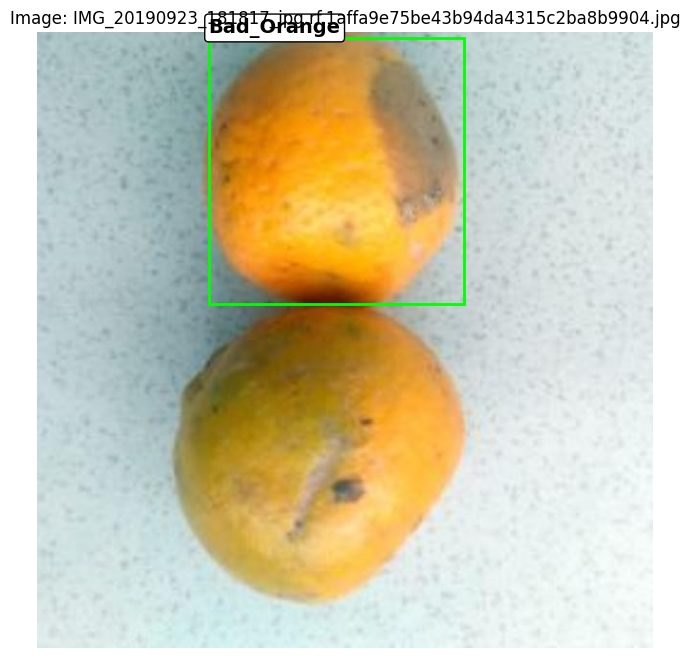

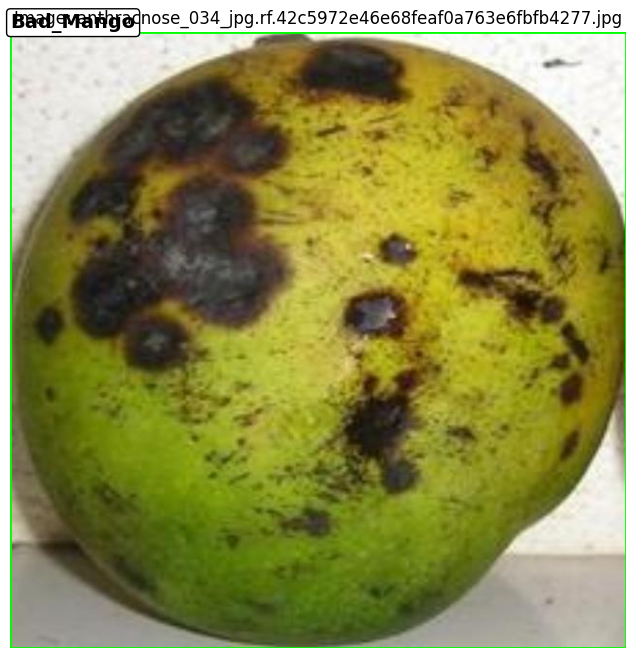

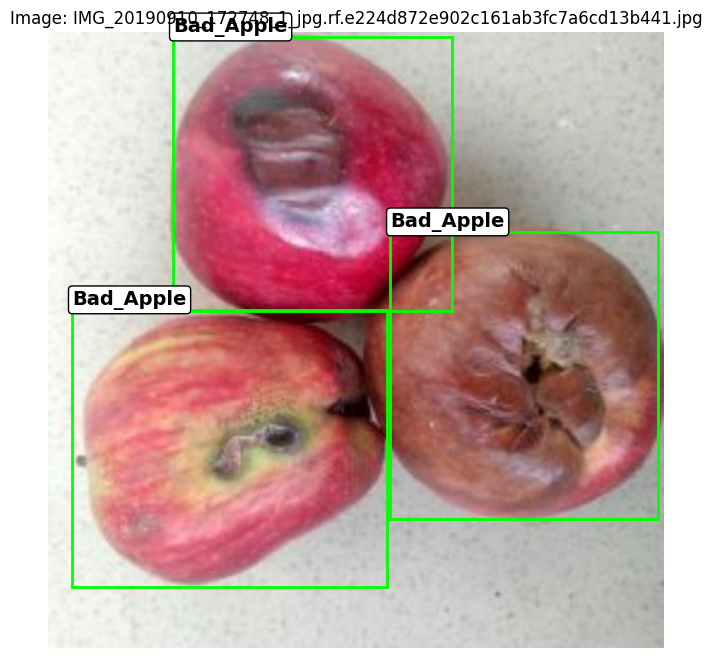

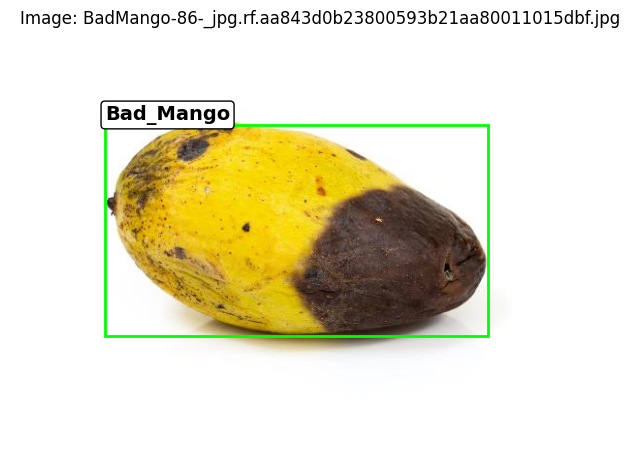

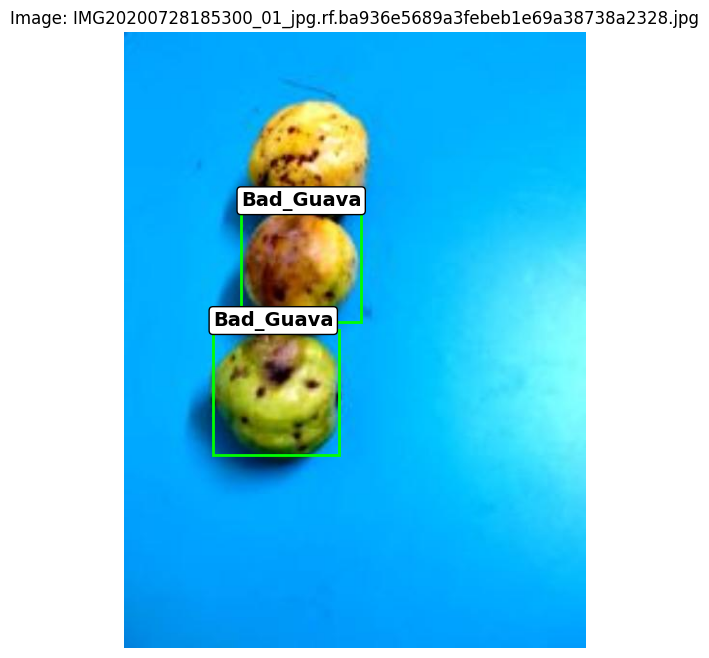

In [6]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Paths to images and labels
image_dir = "/kaggle/input/fruit-yield/FruitYield DataSet/Fruit_Annotation_Object_Det-14/train/images"
label_dir = "/kaggle/input/fruit-yield/FruitYield DataSet/Fruit_Annotation_Object_Det-14/train/labels"

# Your class names
class_names = [
    'Bad_Apple',
    'Bad_Guava',
    'Bad_Mango',
    'Bad_Orange',
    'Good_Apple',
    'Good_Guava',
    'Good_Mango',
    'Good_Orange'
]

# Get list of image files (filter for .jpg or .png)
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))][:6]

# Loop over the first 6 images
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    label_file = image_file.rsplit('.', 1)[0] + ".txt"
    label_path = os.path.join(label_dir, label_file)

    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # Plot image
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    # Read label file and draw bounding boxes
    if os.path.exists(label_path):
        with open(label_path, "r") as file:
            for line in file.readlines():
                parts = line.strip().split()
                class_id, x_center, y_center, box_width, box_height = map(float, parts)

                # Convert to absolute coordinates
                x_center *= w
                y_center *= h
                box_width *= w
                box_height *= h
                x_min = x_center - box_width / 2
                y_min = y_center - box_height / 2

                # Draw bounding box
                rect = patches.Rectangle((x_min, y_min), box_width, box_height,
                                         linewidth=2, edgecolor='lime', facecolor='none')
                ax.add_patch(rect)

                # Draw label using class name with larger black text and background
                class_name = class_names[int(class_id)]
                ax.text(
                    x_min, y_min - 5, class_name,
                    color='black', fontsize=14, weight='bold',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
                )

    ax.set_title(f"Image: {image_file}")
    ax.axis('off')
    plt.show()


In [7]:
yaml_content = """
train: /kaggle/working/augmented_dataset/images
val: /kaggle/input/fruit-yield/FruitYield DataSet/Fruit_Annotation_Object_Det-14/valid/images

nc: 8

names:
  - Bad_Apple
  - Bad_Guava
  - Bad_Mango
  - Bad_Orange
  - Good_Apple
  - Good_Guava
  - Good_Mango
  - Good_Orange
"""

with open('/kaggle/working/augmented_dataset/data.yaml', 'w') as f:
    f.write(yaml_content.strip())


In [8]:
import os

yaml_path = "/kaggle/working/augmented_dataset/data.yaml"

if os.path.exists(yaml_path):
    print("✅ data.yaml file exists.")
else:
    print("❌ data.yaml file does NOT exist.")


✅ data.yaml file exists.


In [9]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.1/994.1 kB 23.6 MB/s eta 0:00:0000:01


In [10]:
from ultralytics import YOLO

# ✅ Load the pretrained YOLOv8 model
model = YOLO('yolov8s.pt')  # or 'yolov8n.pt' for faster training on limited compute

# ✅ Start training
results = model.train(
    data='/kaggle/working/augmented_dataset/data.yaml',  # Path to your dataset YAML
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=0.001,
    project='/kaggle/working',  # 🔸 Save all outputs here
    name='fruit_detection_clean',  # 🔸 Folder name under /kaggle/working
    verbose=True,
    plots=True  # 🔸 Ensures all result graphs like F1 curve are saved
)

print("✅ Training completed successfully!")

# ✅ Output path
result_dir = '/kaggle/working/fruit_detection_clean'
print(f"\n📂 All results saved in: {result_dir}")

# You’ll find:
# 📉 training results.png (losses, mAP, precision, recall)
# 📊 confusion_matrix.png
# 📈 F1 curve, PR curve, labels.png
# 💾 weights/best.pt and last.pt (for inference)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 254MB/s]


Ultralytics 8.3.104 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/augmented_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working, name=fruit_detection_clean, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

100%|██████████| 755k/755k [00:00<00:00, 29.3MB/s]


Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 118MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/augmented_dataset/labels... 2358 images, 14 backgrounds, 0 corrupt: 100%|██████████| 2358/2358 [00:01<00:00, 1228.52it/s]


train: New cache created: /kaggle/working/augmented_dataset/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/fruit-yield/FruitYield DataSet/Fruit_Annotation_Object_Det-14/valid/labels... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<00:00, 155.47it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/fruit-yield/FruitYield DataSet/Fruit_Annotation_Object_Det-14/valid is not writeable, cache not saved.


Plotting labels to /kaggle/working/fruit_detection_clean/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/fruit_detection_clean
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.77G     0.6004      2.186      1.135         16        640: 100%|██████████| 148/148 [00:38<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all        141        202      0.658      0.664        0.7      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.77G     0.6115      1.187      1.101         14        640: 100%|██████████| 148/148 [00:36<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]

                   all        141        202      0.677      0.629      0.725      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.79G     0.6254      1.138      1.103         14        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]

                   all        141        202      0.657      0.671      0.718       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.79G     0.6119      1.055      1.106         16        640: 100%|██████████| 148/148 [00:37<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]

                   all        141        202      0.644      0.806      0.789      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.79G     0.5862     0.9775      1.089         17        640: 100%|██████████| 148/148 [00:37<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]

                   all        141        202      0.789      0.712      0.824      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.79G       0.58     0.9329      1.077         19        640: 100%|██████████| 148/148 [00:37<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]

                   all        141        202      0.728      0.714      0.777      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.79G     0.5731     0.8956      1.078         16        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]

                   all        141        202      0.826       0.77      0.849      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.79G     0.5511     0.8505      1.065         17        640: 100%|██████████| 148/148 [00:37<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]

                   all        141        202      0.799      0.837      0.894      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.79G     0.5445     0.7938      1.058         14        640: 100%|██████████| 148/148 [00:37<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]

                   all        141        202      0.727      0.841      0.893        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.79G     0.5261     0.7838      1.042         18        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]

                   all        141        202      0.818      0.775      0.849      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.79G     0.5283     0.7413      1.051         17        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all        141        202      0.809      0.776      0.869      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.79G     0.5096     0.6977      1.038         20        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]

                   all        141        202        0.8       0.86      0.908      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.79G     0.5059     0.6799      1.035         22        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]

                   all        141        202      0.898      0.808      0.907      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.79G      0.502     0.6693      1.032         16        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]

                   all        141        202      0.872      0.852       0.91      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.79G     0.4975     0.6625       1.03         15        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]

                   all        141        202      0.783      0.848      0.897      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.79G      0.486     0.6232      1.022         19        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]

                   all        141        202      0.871      0.788      0.901      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.79G     0.4823     0.6082      1.024         15        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]

                   all        141        202      0.801      0.881      0.906      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.79G     0.4743     0.5943      1.016         12        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]

                   all        141        202      0.841      0.818      0.896      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.79G     0.4753      0.583       1.02         18        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

                   all        141        202      0.848      0.829      0.891      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.79G     0.4639     0.5764      1.014         14        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

                   all        141        202      0.881      0.861      0.921      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.79G     0.4652     0.5465      1.012         20        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]

                   all        141        202      0.858      0.871      0.923      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.79G     0.4617     0.5458      1.012         15        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]

                   all        141        202      0.894      0.869      0.917      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.79G      0.457     0.5079       1.01         14        640: 100%|██████████| 148/148 [00:37<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

                   all        141        202      0.823      0.861      0.907      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.79G     0.4444       0.49      1.004         14        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]

                   all        141        202      0.853      0.863      0.927       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.79G     0.4379     0.5052     0.9961         14        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]

                   all        141        202      0.879      0.816      0.911       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.79G     0.4468     0.4953      1.007         20        640: 100%|██████████| 148/148 [00:37<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]

                   all        141        202       0.89      0.821      0.913      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.79G     0.4408     0.4748      1.002         16        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]

                   all        141        202      0.827      0.866      0.911      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.79G     0.4301     0.4574     0.9901         19        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]

                   all        141        202      0.926      0.824      0.919      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.79G     0.4365     0.4615     0.9964         20        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

                   all        141        202      0.889      0.874      0.938      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.79G     0.4297     0.4476     0.9885         13        640: 100%|██████████| 148/148 [00:37<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

                   all        141        202      0.806      0.851      0.913      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.79G      0.431      0.442     0.9951         16        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]

                   all        141        202      0.842      0.879      0.926      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.79G      0.431     0.4482     0.9961         17        640: 100%|██████████| 148/148 [00:37<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

                   all        141        202      0.868      0.883      0.932      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.79G     0.4219     0.4266     0.9985         11        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        141        202      0.879       0.85       0.91       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.79G     0.4196     0.4228     0.9918         16        640: 100%|██████████| 148/148 [00:37<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.74it/s]

                   all        141        202      0.891      0.868      0.925      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.79G     0.4045     0.3955     0.9826         25        640: 100%|██████████| 148/148 [00:37<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

                   all        141        202      0.913      0.872      0.941      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.79G     0.4098     0.4094     0.9841         18        640: 100%|██████████| 148/148 [00:37<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]

                   all        141        202      0.852      0.892       0.92      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.79G     0.3961      0.391     0.9708         16        640: 100%|██████████| 148/148 [00:37<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

                   all        141        202       0.91      0.858      0.935      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.79G     0.4025     0.3881     0.9878         21        640: 100%|██████████| 148/148 [00:37<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]

                   all        141        202      0.873      0.886      0.937      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.79G     0.3902     0.3789     0.9736         14        640: 100%|██████████| 148/148 [00:37<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]

                   all        141        202      0.926      0.883      0.928      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.79G     0.3895     0.3708     0.9718         18        640: 100%|██████████| 148/148 [00:37<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]

                   all        141        202      0.906      0.889      0.929      0.877


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.79G     0.3077      0.289     0.9164         12        640: 100%|██████████| 148/148 [00:37<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]

                   all        141        202      0.905      0.871      0.925      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.79G     0.3085     0.2777     0.9259          8        640: 100%|██████████| 148/148 [00:37<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]

                   all        141        202      0.923      0.881      0.938      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.79G     0.2995     0.2638     0.9102          6        640: 100%|██████████| 148/148 [00:37<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]

                   all        141        202      0.874      0.888      0.941      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.79G     0.2934     0.2594     0.9056         10        640: 100%|██████████| 148/148 [00:37<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]

                   all        141        202      0.872      0.851      0.923      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.79G     0.2874     0.2504     0.9054          7        640: 100%|██████████| 148/148 [00:36<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]

                   all        141        202      0.879      0.865      0.919      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.79G     0.2882     0.2358     0.9047         10        640: 100%|██████████| 148/148 [00:37<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]

                   all        141        202      0.904       0.86      0.921      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.79G     0.2814     0.2374     0.9017          7        640: 100%|██████████| 148/148 [00:37<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]

                   all        141        202      0.889      0.863      0.917      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.79G     0.2741     0.2252     0.9026          8        640: 100%|██████████| 148/148 [00:37<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]

                   all        141        202      0.899      0.865      0.929      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.79G     0.2703     0.2227     0.8958          7        640: 100%|██████████| 148/148 [00:37<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

                   all        141        202      0.901      0.863      0.931      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.79G     0.2682      0.217     0.8936          8        640: 100%|██████████| 148/148 [00:37<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]

                   all        141        202      0.883       0.88      0.925      0.877



50 epochs completed in 0.542 hours.
Optimizer stripped from /kaggle/working/fruit_detection_clean/weights/last.pt, 22.5MB
Optimizer stripped from /kaggle/working/fruit_detection_clean/weights/best.pt, 22.5MB

Validating /kaggle/working/fruit_detection_clean/weights/best.pt...
Ultralytics 8.3.104 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


                   all        141        202      0.874      0.888      0.941      0.884
             Bad_Apple         25         26      0.904          1      0.995       0.96
             Bad_Guava         15         19      0.929          1       0.98      0.899
             Bad_Mango         14         17      0.964          1      0.995      0.958
            Bad_Orange         27         36      0.969       0.88      0.984      0.952
            Good_Apple         15         31      0.863      0.871      0.939      0.886
            Good_Guava         15         26       0.89      0.625      0.828      0.732
            Good_Mango         15         29      0.709       0.84       0.89      0.816
           Good_Orange         15         18      0.761      0.883      0.917      0.866


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 5.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /kaggle/working/fruit_detection_clean
✅ Training completed successfully!

📂 All results saved in: /kaggle/working/fruit_detection_clean



0: 640x640 1 Good_Guava, 16.2ms
Speed: 1.4ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


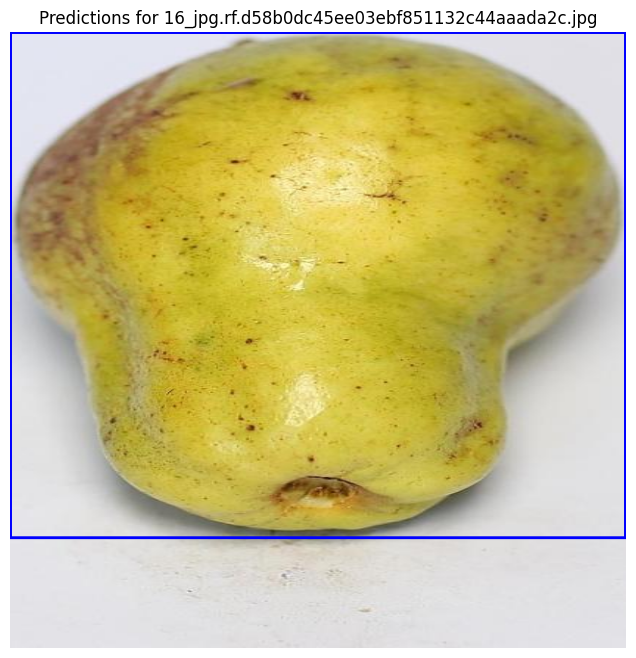

In [19]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

# ✅ Load the latest trained model
model_path = "/kaggle/working/fruit_detection_clean/weights/best.pt"  # Update path if needed
model = YOLO(model_path)

# ✅ Select an image for testing
test_image_path = "/kaggle/input/fruit-yield/FruitYield DataSet/Fruit_Annotation_Object_Det-14/train/images/16_jpg.rf.d58b0dc45ee03ebf851132c44aaada2c.jpg"

# ✅ Resize the image to match training size
image = cv2.imread(test_image_path)
image = cv2.resize(image, (640, 640))  # Resize to 640x640 for consistency

# ✅ Run inference with a lower confidence threshold
results = model.predict(image, conf=0.25)  # Try lowering confidence

# ✅ Draw bounding boxes and labels
for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()
    scores = result.boxes.conf.cpu().numpy()
    class_ids = result.boxes.cls.cpu().numpy()
    class_names = result.names

    for box, score, class_id in zip(boxes, scores, class_ids):
        if score >= 0.25:  # Lower threshold
            x1, y1, x2, y2 = map(int, box)
            label = f"{class_names[int(class_id)]} {score:.2f}"
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw bounding box
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)  # Draw label

# ✅ Display the image with detections
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Predictions for {os.path.basename(test_image_path)}")
plt.axis('off')
plt.show()

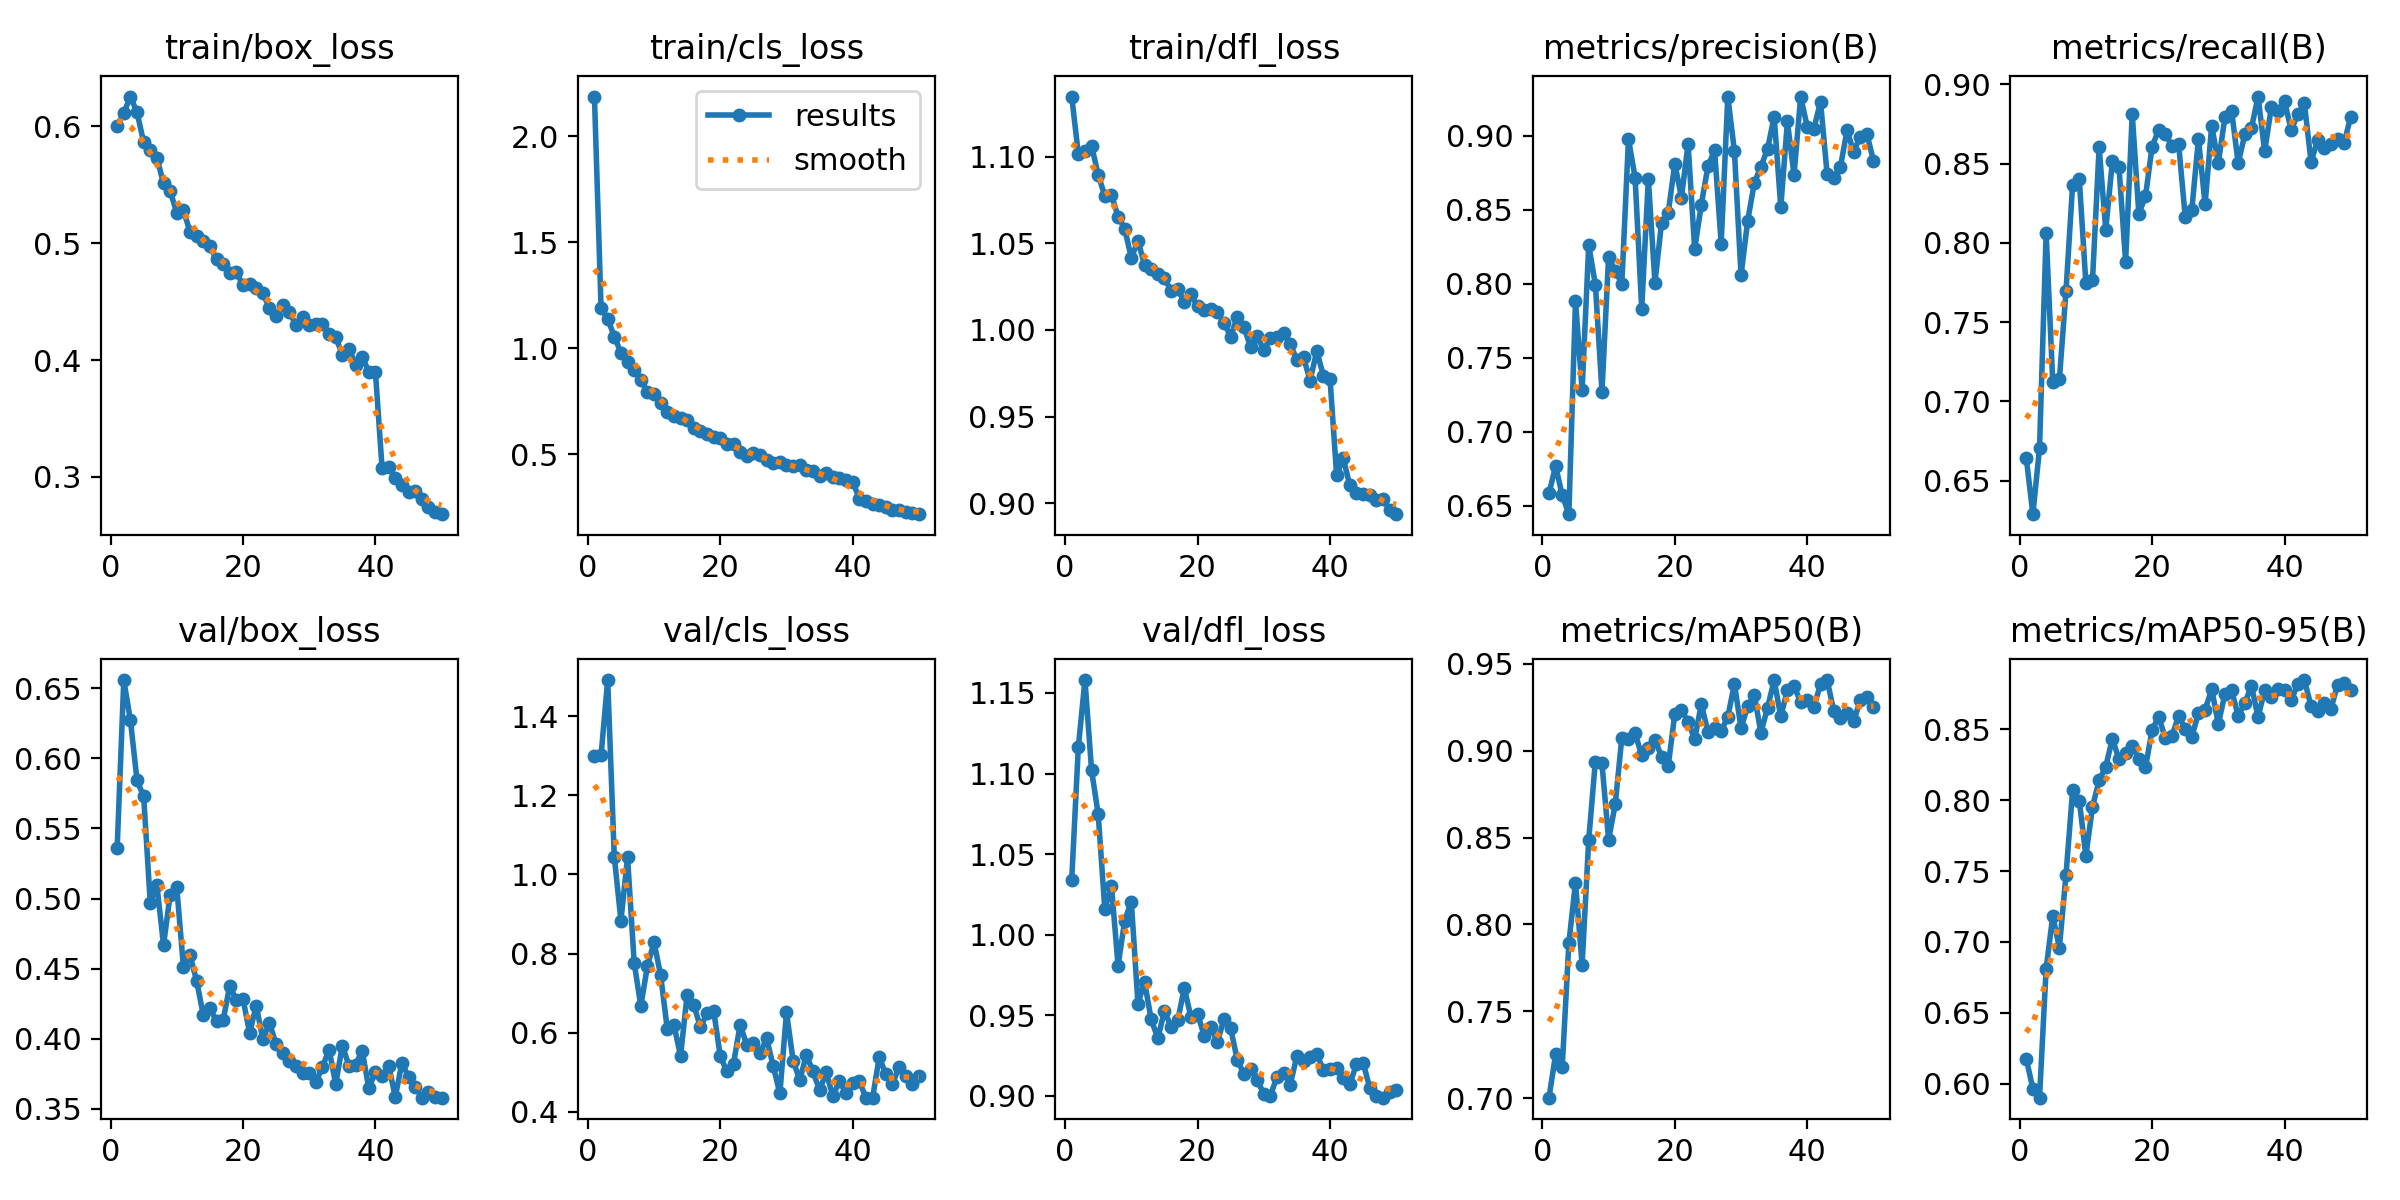

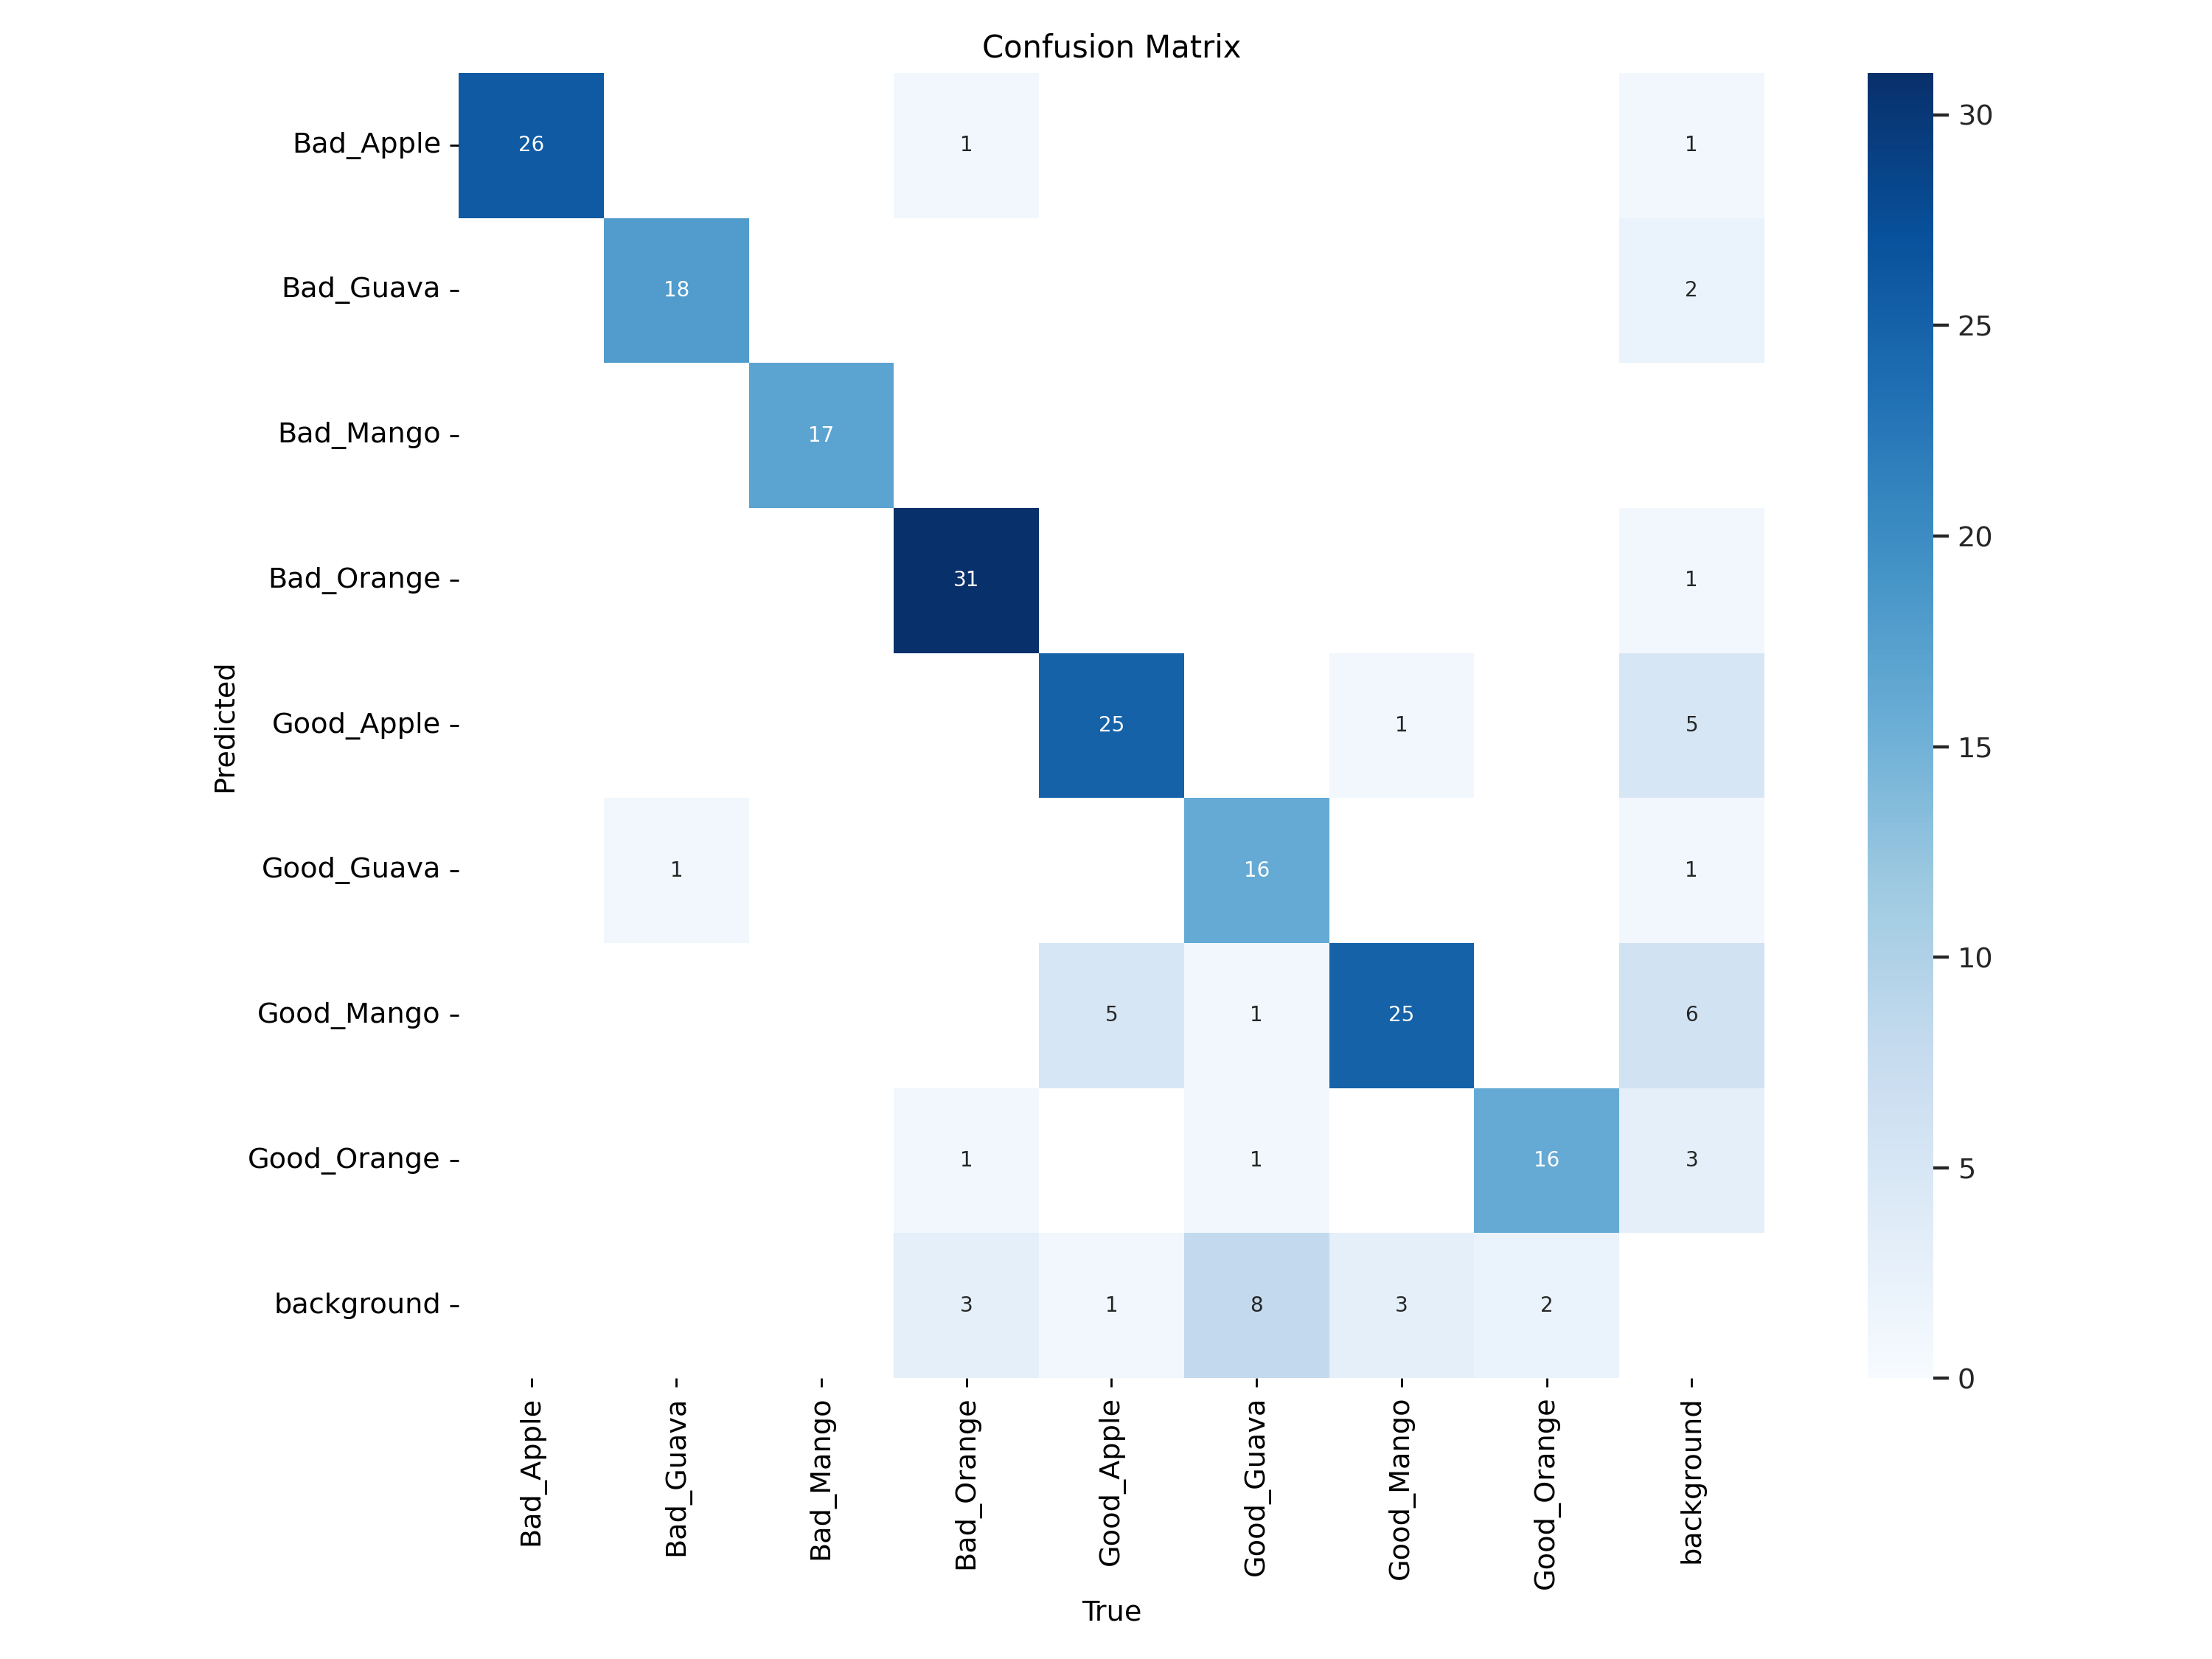

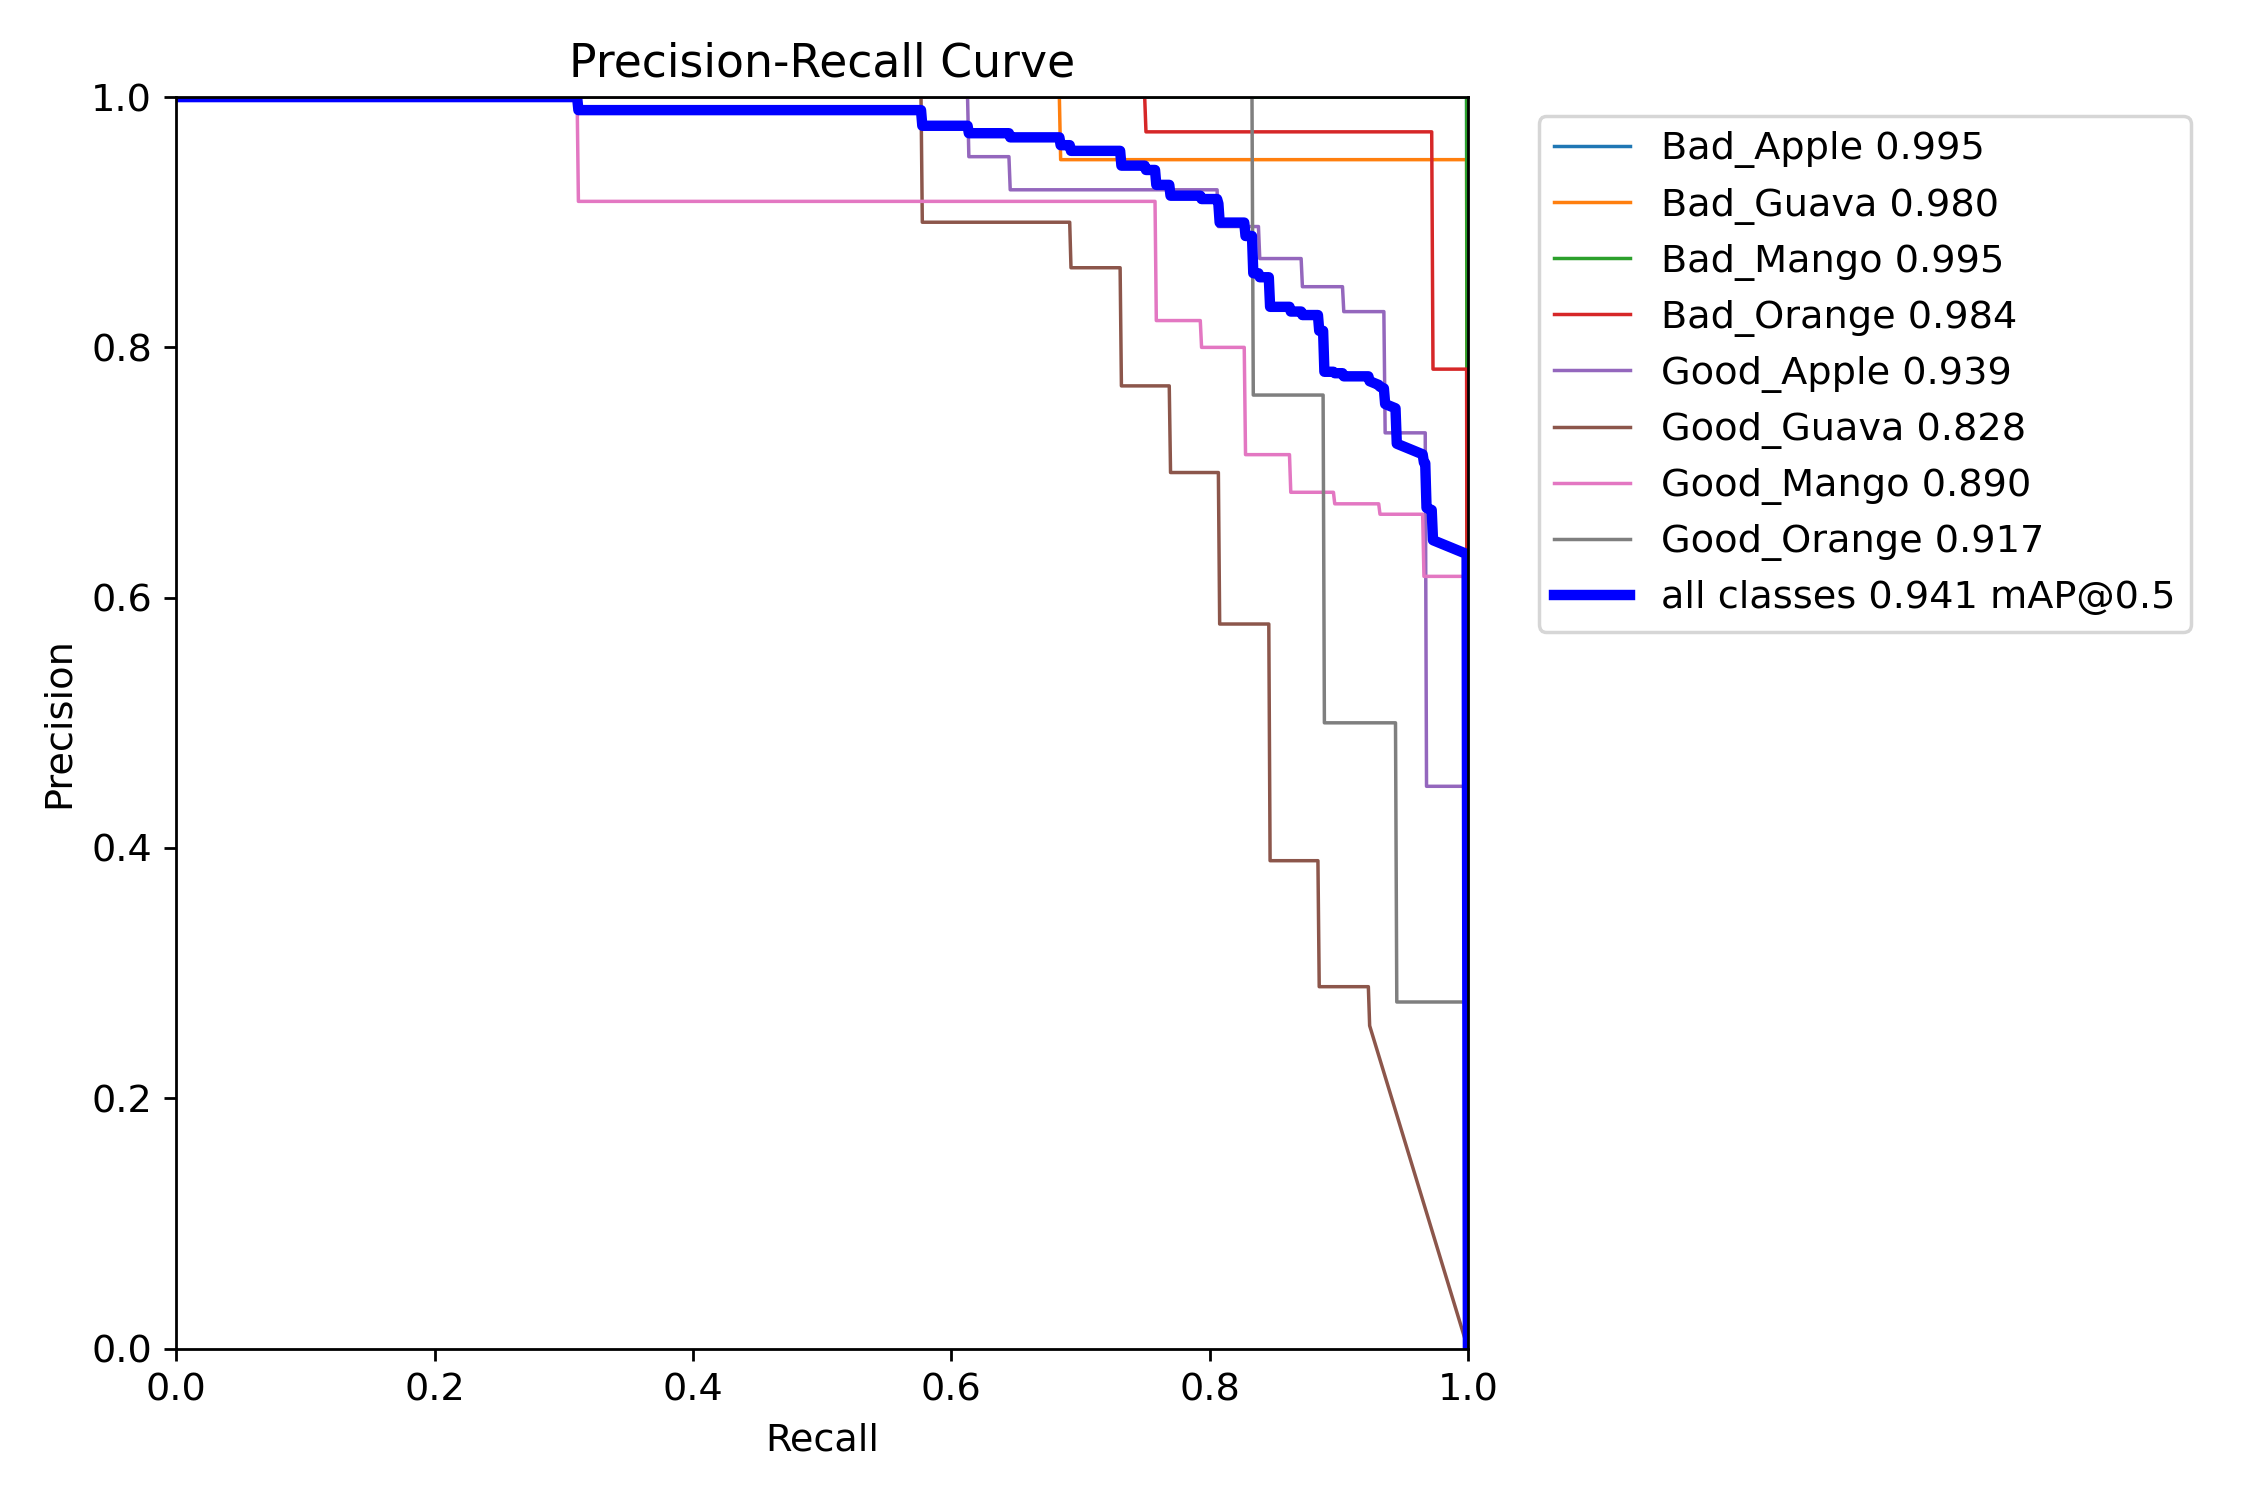

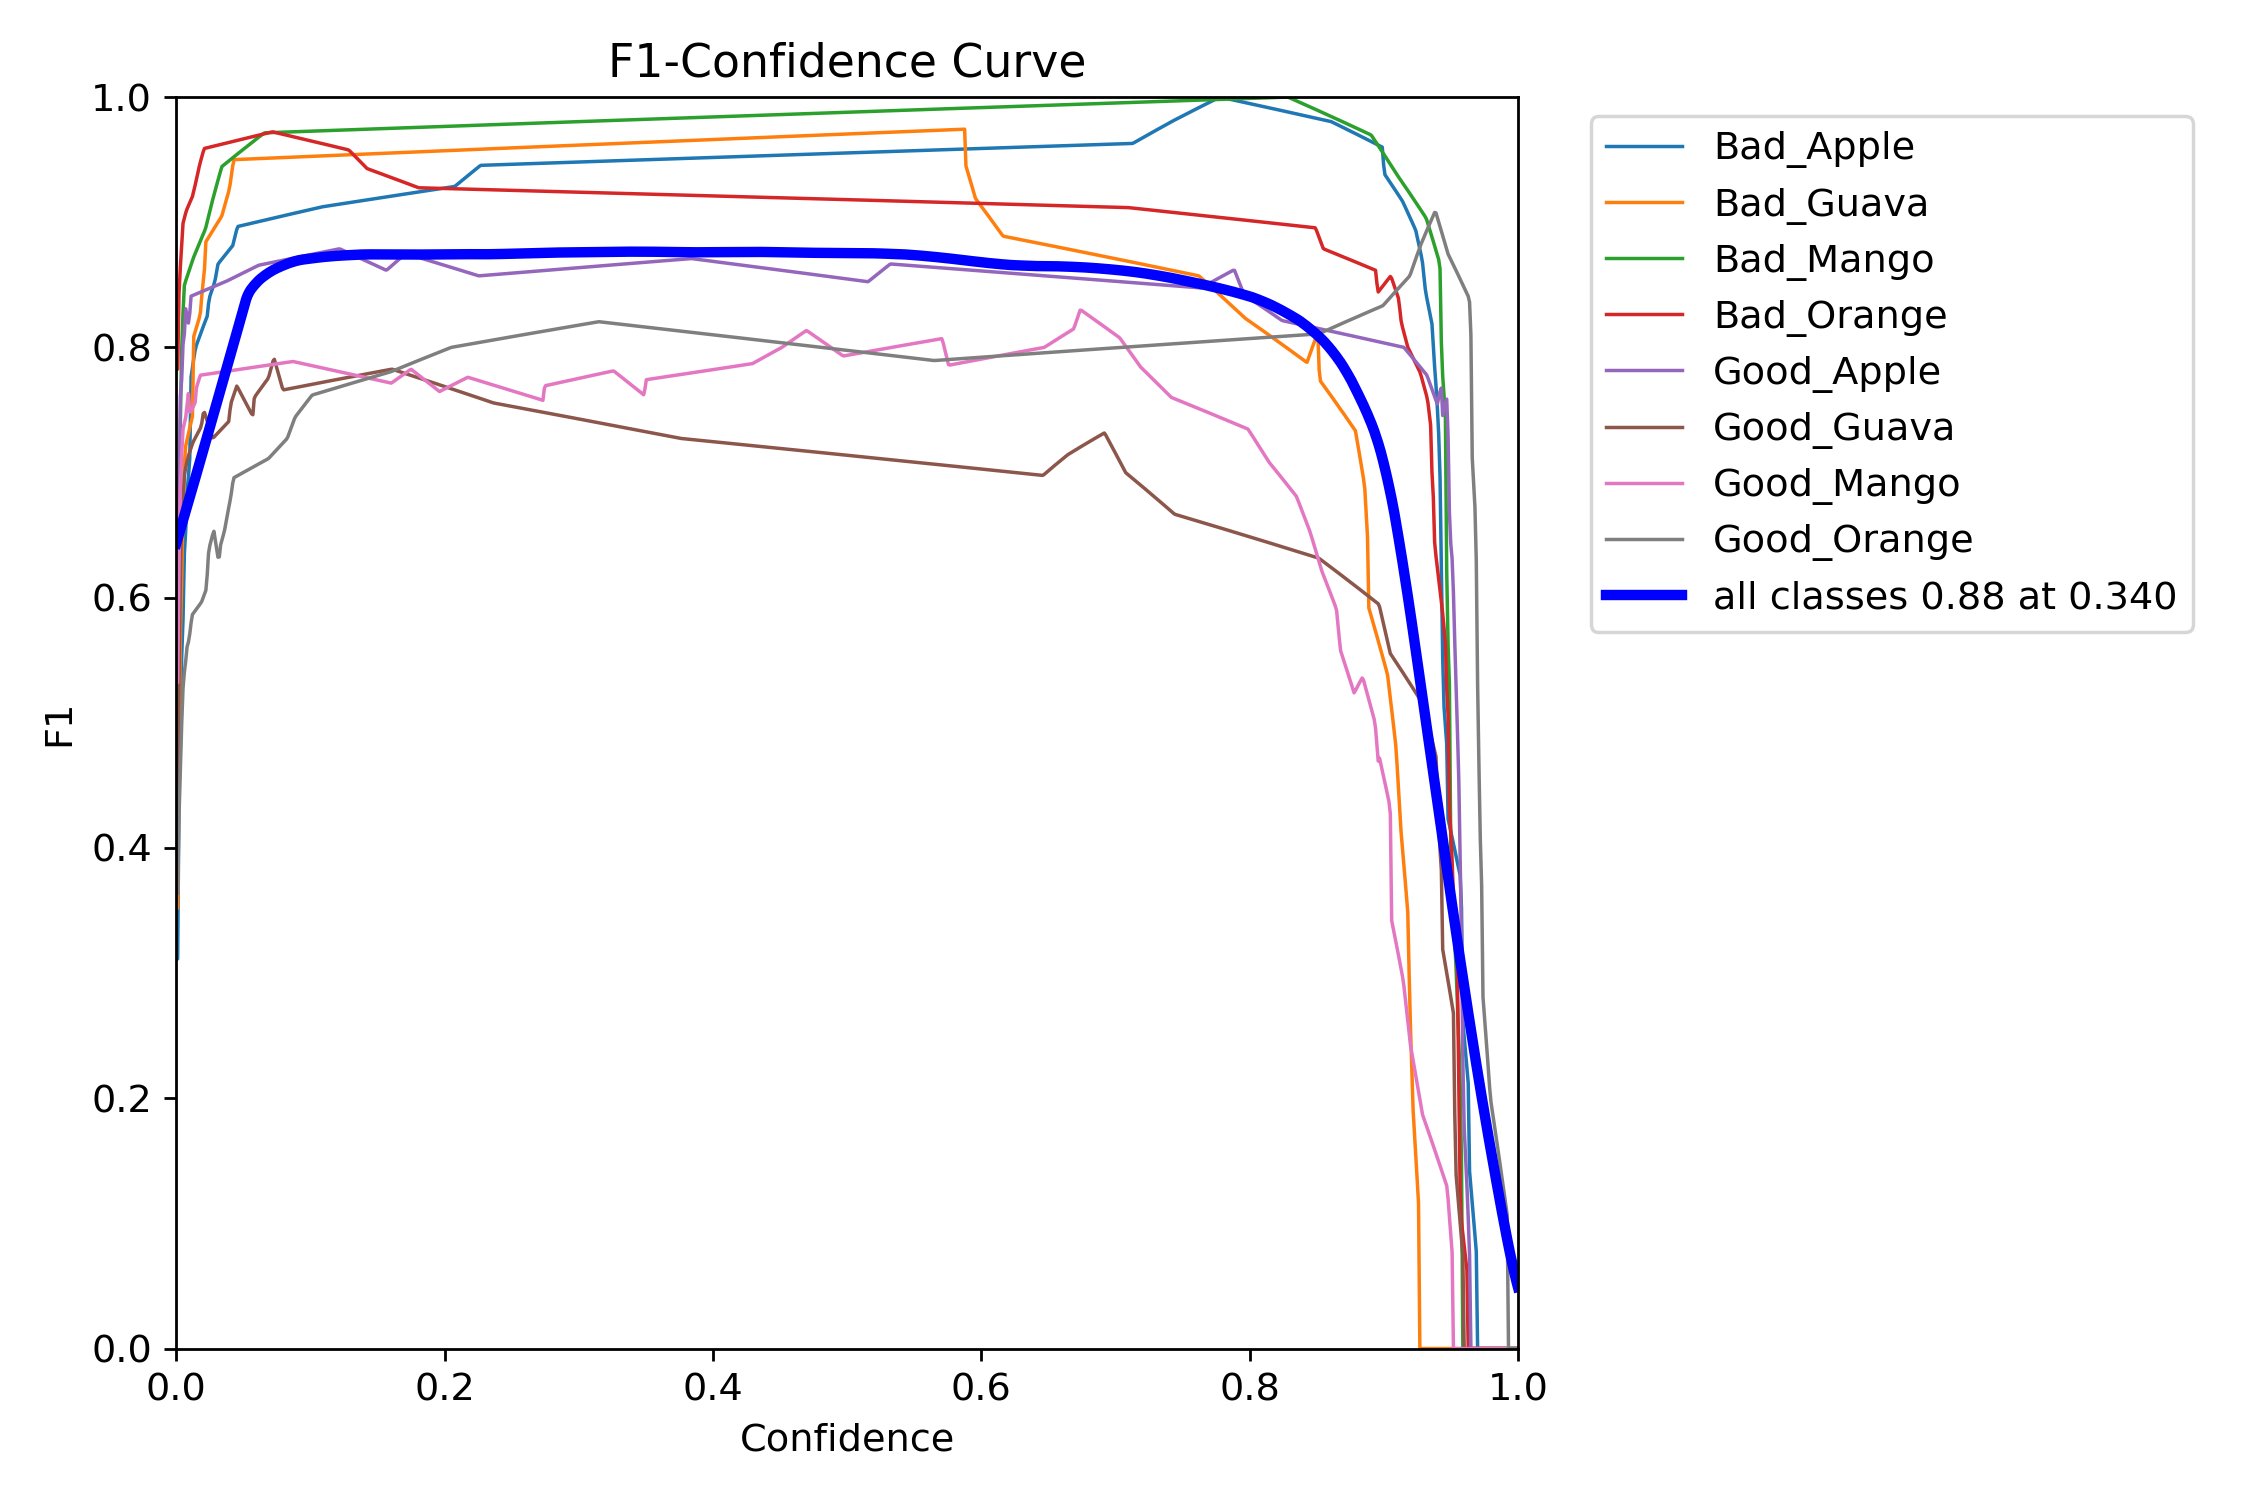

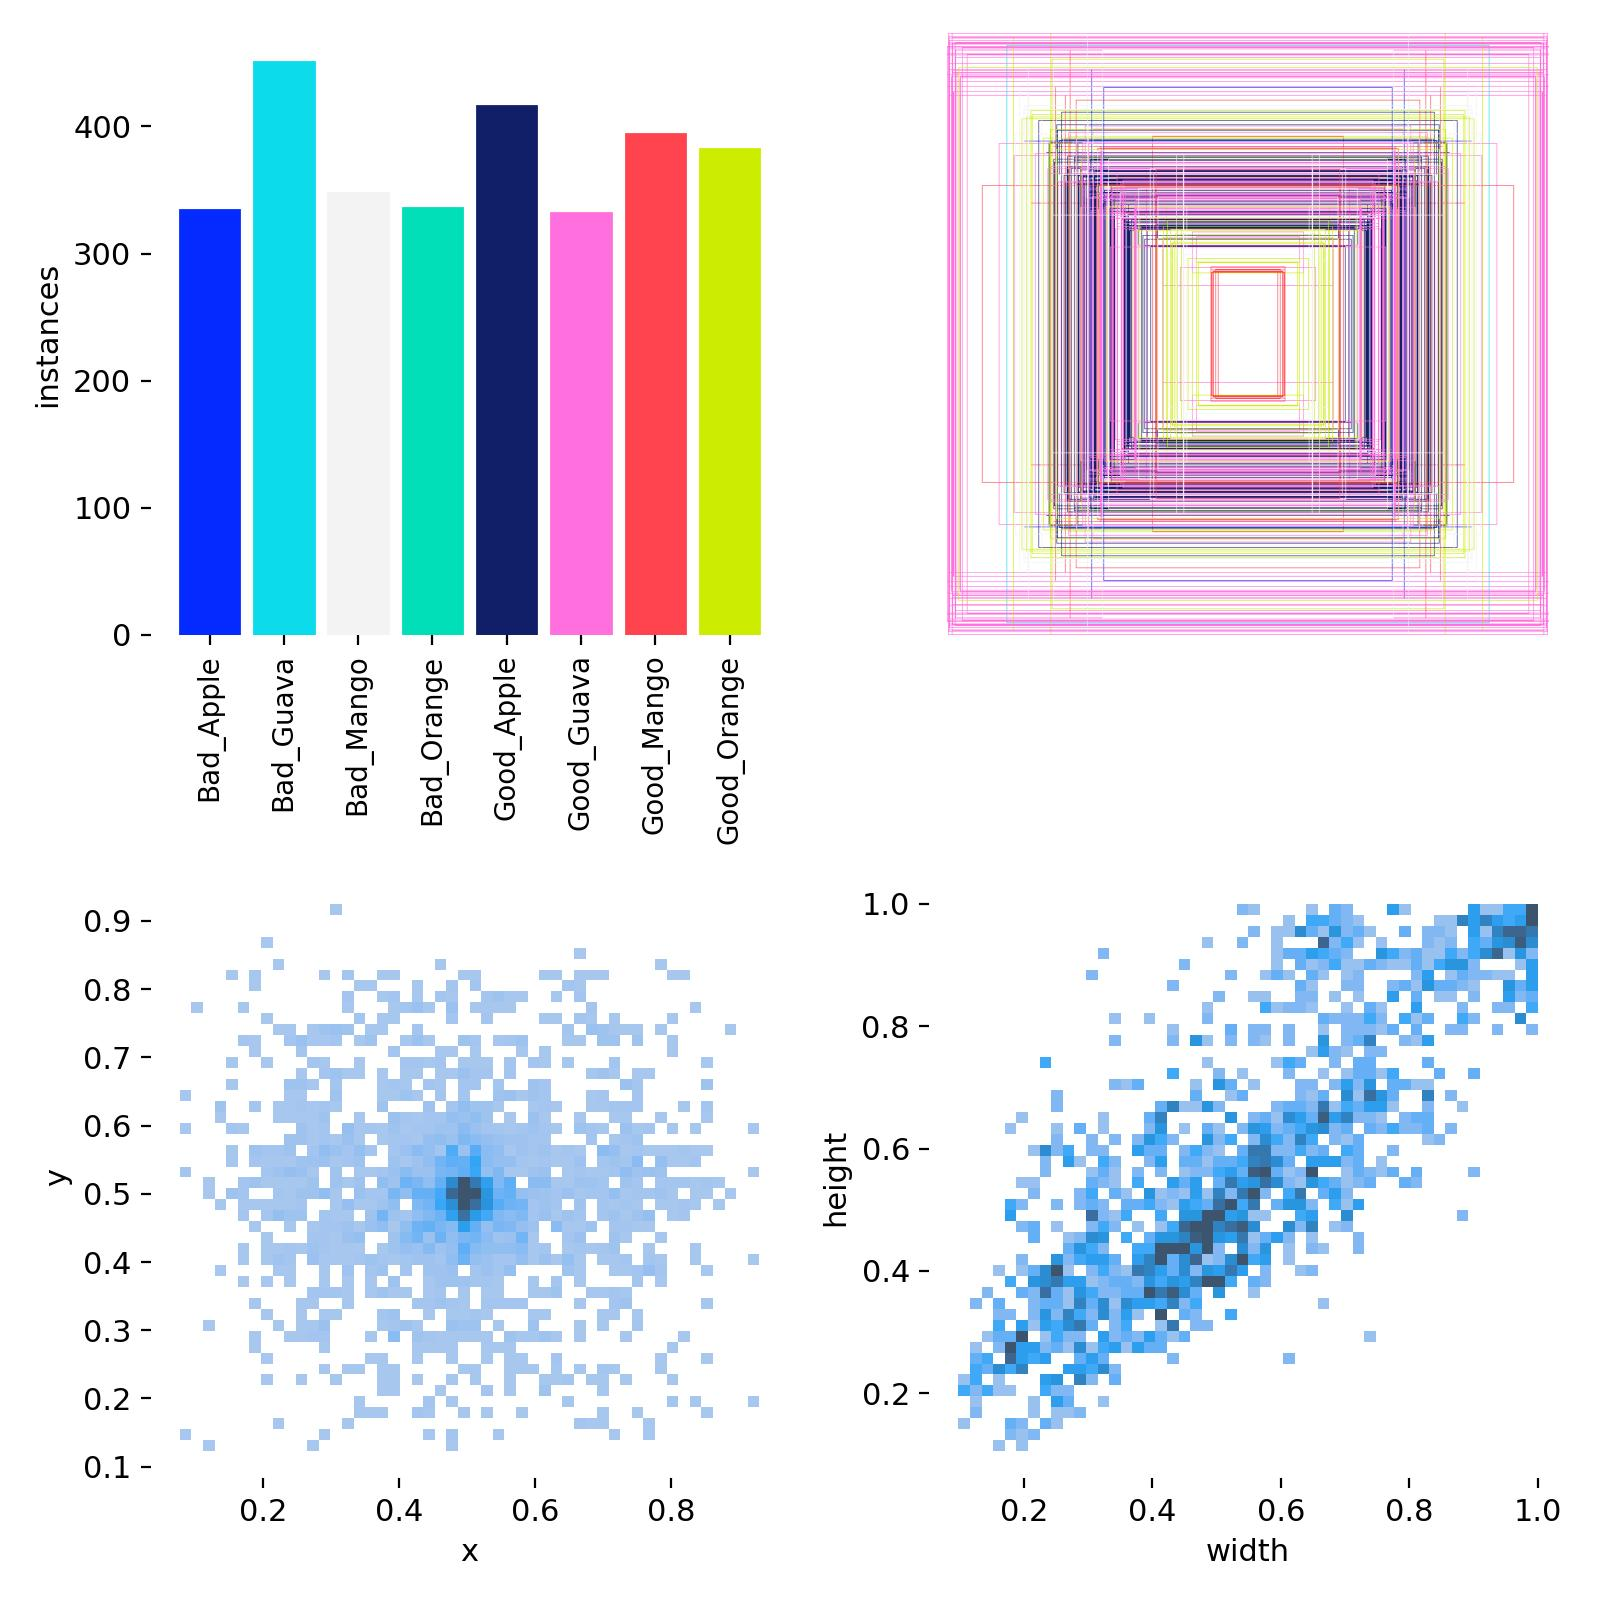

In [12]:
from IPython.display import Image, display

# Training curves (losses, mAP, etc.)
display(Image('/kaggle/working/fruit_detection_clean/results.png'))

# Confusion matrix
display(Image('/kaggle/working/fruit_detection_clean/confusion_matrix.png'))

# Precision-Recall curve
display(Image('/kaggle/working/fruit_detection_clean/PR_curve.png'))

# F1 score vs confidence
display(Image('/kaggle/working/fruit_detection_clean/F1_curve.png'))

# Optional: label previews
display(Image('/kaggle/working/fruit_detection_clean/labels.jpg'))


In [13]:
import pandas as pd

df = pd.read_csv('/kaggle/working/fruit_detection_clean/results.csv')
print(df.head())  # see first few rows


   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   44.7990         0.60037         2.18619         1.13464   
1      2   83.1194         0.61148         1.18738         1.10137   
2      3  122.6760         0.62540         1.13799         1.10324   
3      4  161.8340         0.61187         1.05455         1.10620   
4      5  200.8400         0.58625         0.97749         1.08945   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.65845            0.66429           0.70029   
1               0.67693            0.62892           0.72528   
2               0.65719            0.67057           0.71805   
3               0.64445            0.80625           0.78922   
4               0.78852            0.71216           0.82401   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.61767       0.53614       1.30008       1.03412  0.000276   
1              0.59633       0.65588  

In [14]:
import pandas as pd

df = pd.read_csv('/kaggle/working/fruit_detection_clean/results.csv')
print(f"Total epochs recorded: {len(df)}")
df.tail()  # shows the last few epochs


Total epochs recorded: 50


epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
45     46  1795.75         0.28816         0.23578         0.90466   
46     47  1834.51         0.28144         0.23742         0.90166   
47     48  1873.15         0.27411         0.22522         0.90264   
48     49  1911.76         0.27033         0.22275         0.89584   
49     50  1950.32         0.26820         0.21699         0.89365   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
45               0.90356            0.85971           0.92144   
46               0.88918            0.86265           0.91686   
47               0.89935            0.86530           0.92888   
48               0.90122            0.86332           0.93090   
49               0.88298            0.87965           0.92515   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
45              0.86825       0.36575       0.47059       0.90501  0.000091   
46              0.86426       0.35804       0.51375       0.89955  0.000074   
47              0.88158       0.36219       0.48991       0.89882  0.000058   
48              0.88296       0.35866       0.47064       0.90258  0.000041   
49              0.87744       0.35797       0.49088       0.90351  0.000025   

      lr/pg1    lr/pg2  
45  0.000091  0.000091  
46  0.000074  0.000074  
47  0.000058  0.000058  
48  0.000041  0.000041  
49  0.000025  0.000025

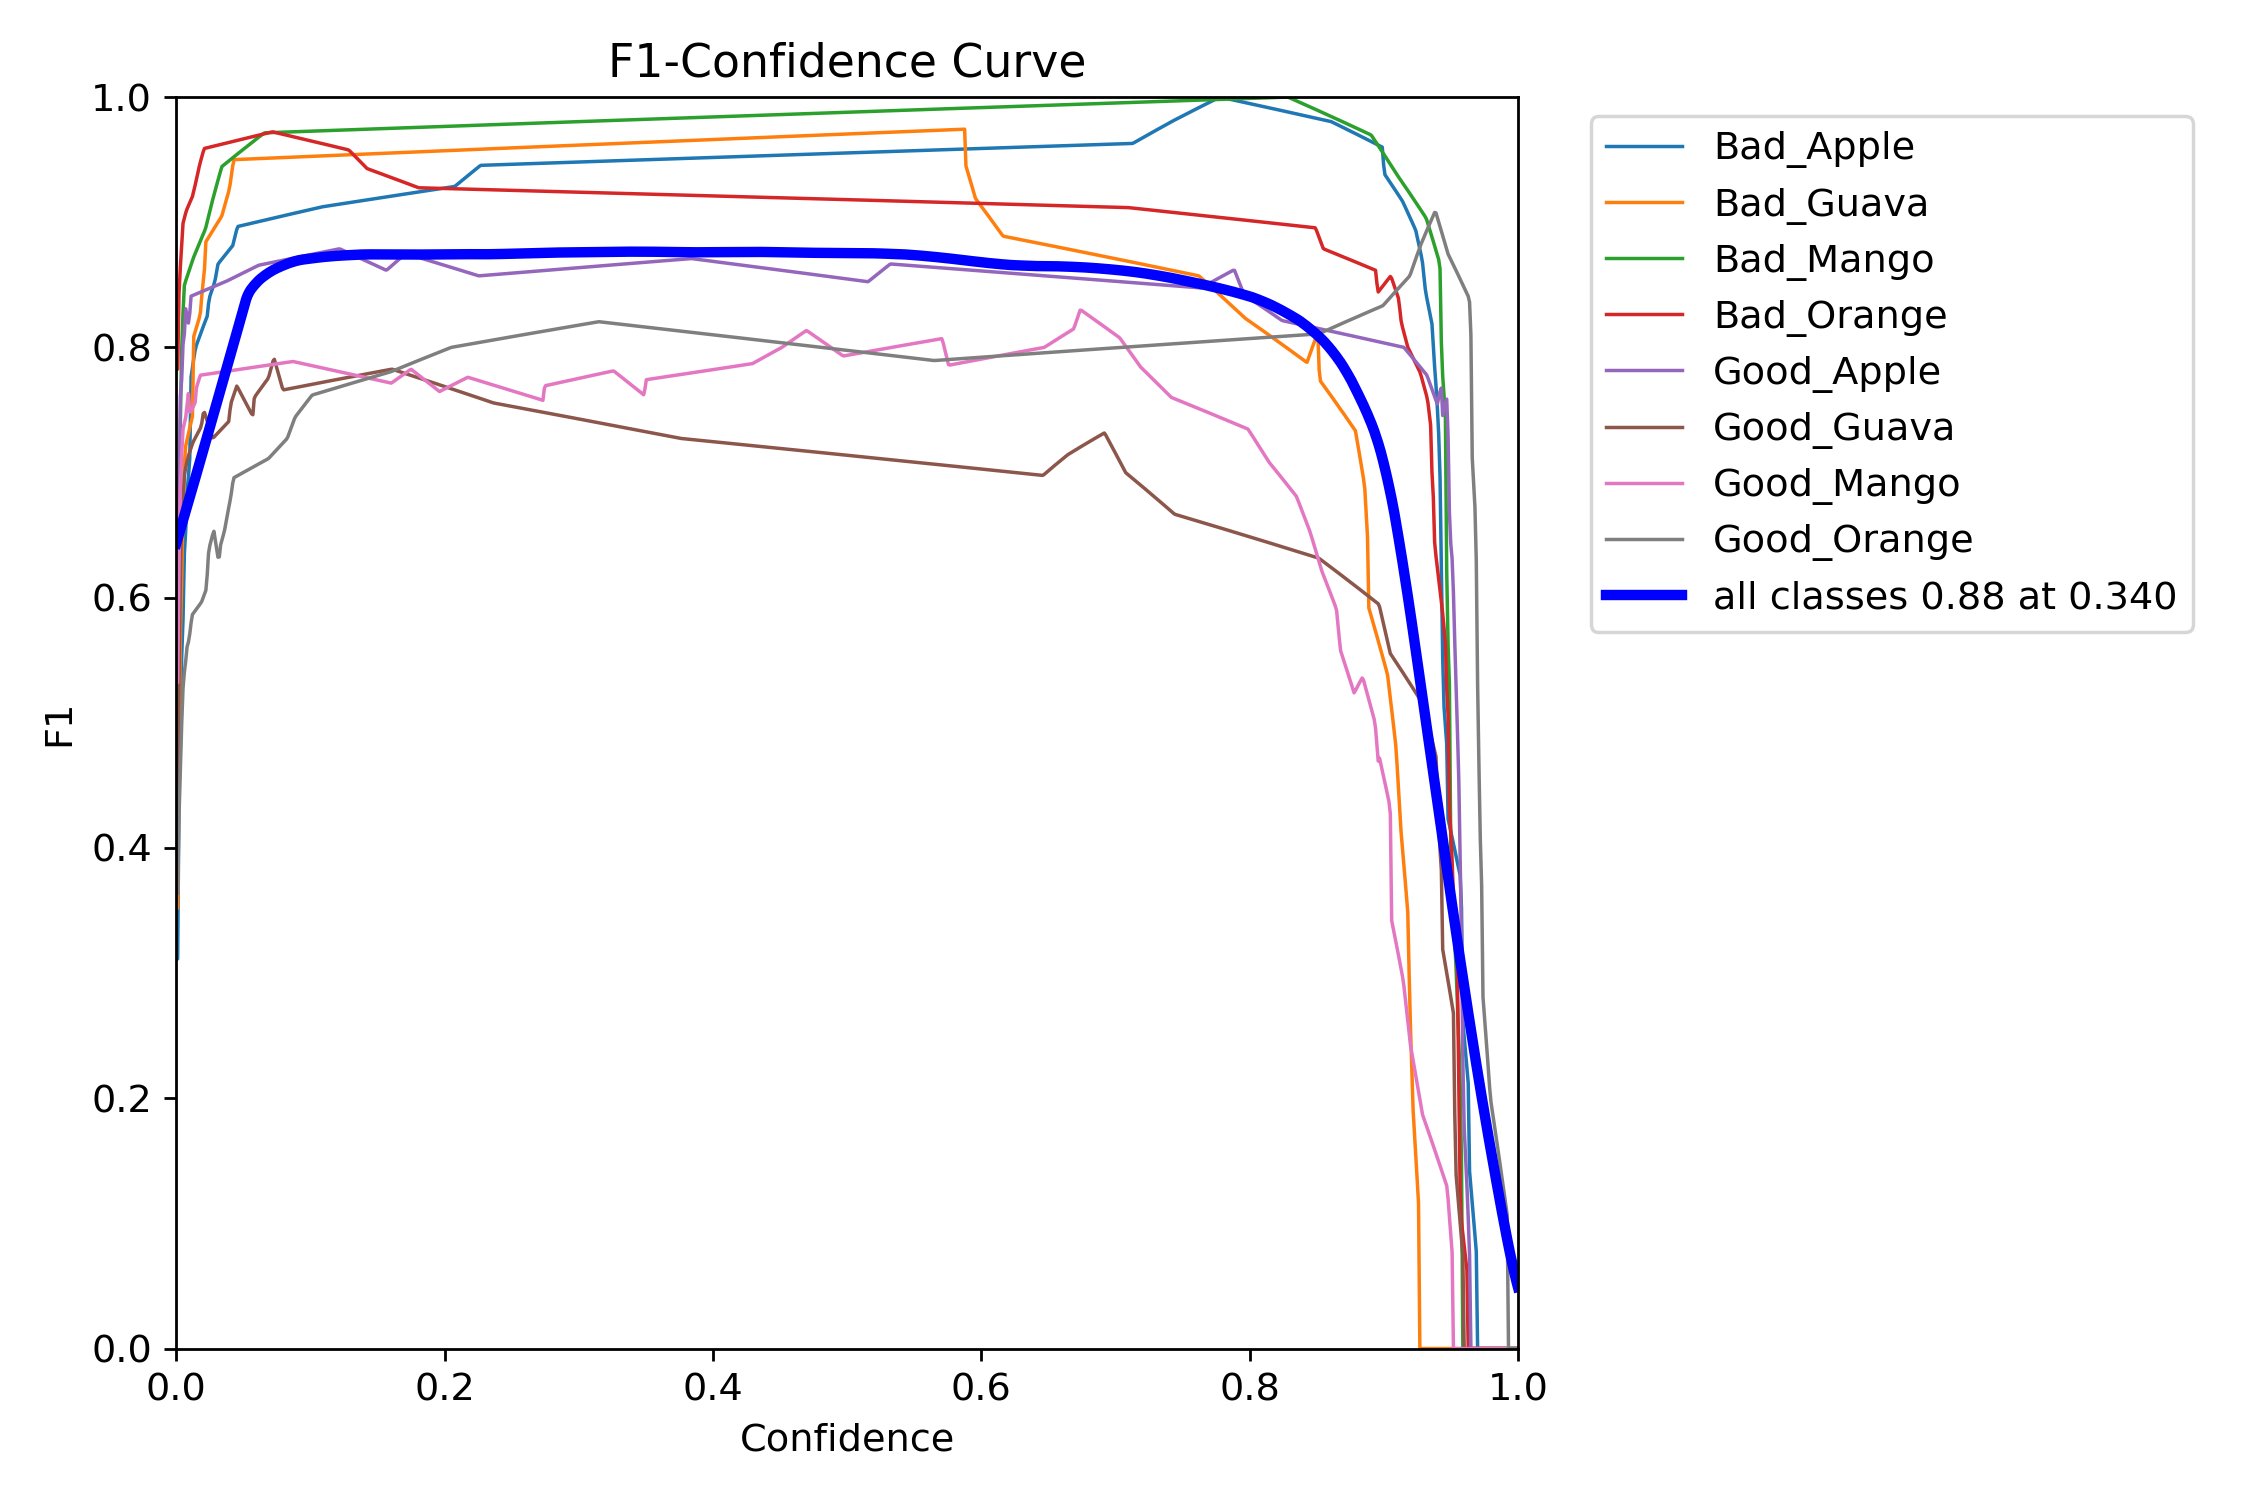

In [15]:
from IPython.display import Image

# Display all important plots
Image(filename='/kaggle/working/fruit_detection_clean/results.png')   # includes loss, metrics
Image(filename='/kaggle/working/fruit_detection_clean/confusion_matrix.png')
Image(filename='/kaggle/working/fruit_detection_clean/PR_curve.png')
Image(filename='/kaggle/working/fruit_detection_clean/F1_curve.png')


In [16]:
import pandas as pd

# Load the results
df = pd.read_csv('/kaggle/working/fruit_detection_clean/results.csv')

# Show all rows (disable row limit)
pd.set_option('display.max_rows', None)

# Display the full DataFrame
print(df)


    epoch       time  train/box_loss  train/cls_loss  train/dfl_loss  \
0       1    44.7990         0.60037         2.18619         1.13464   
1       2    83.1194         0.61148         1.18738         1.10137   
2       3   122.6760         0.62540         1.13799         1.10324   
3       4   161.8340         0.61187         1.05455         1.10620   
4       5   200.8400         0.58625         0.97749         1.08945   
5       6   239.9800         0.57999         0.93293         1.07725   
6       7   278.8720         0.57310         0.89561         1.07799   
7       8   317.9630         0.55107         0.85054         1.06527   
8       9   356.9760         0.54447         0.79384         1.05833   
9      10   395.9640         0.52606         0.78376         1.04151   
10     11   434.9280         0.52831         0.74131         1.05131   
11     12   473.9440         0.50962         0.69768         1.03751   
12     13   512.8850         0.50592         0.67993         1.0


0: 640x640 1 Bad_Apple, 16.2ms
Speed: 1.7ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


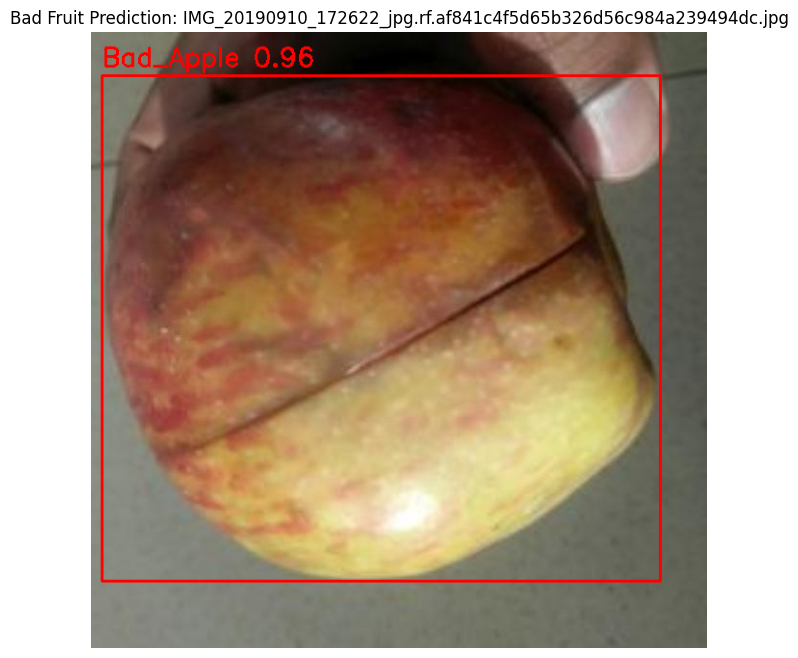


0: 640x640 3 Bad_Guavas, 16.3ms
Speed: 1.7ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


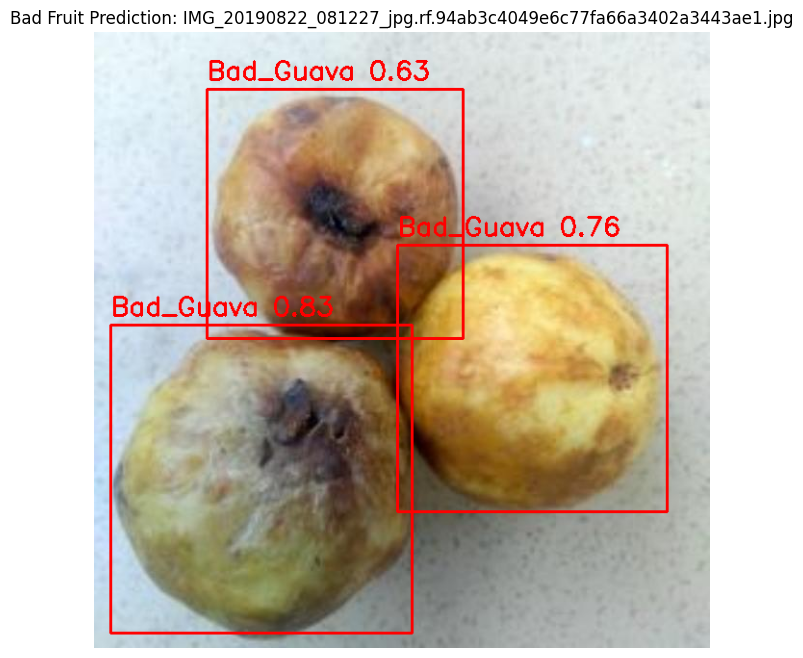


0: 640x640 1 Bad_Mango, 16.3ms
Speed: 1.7ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


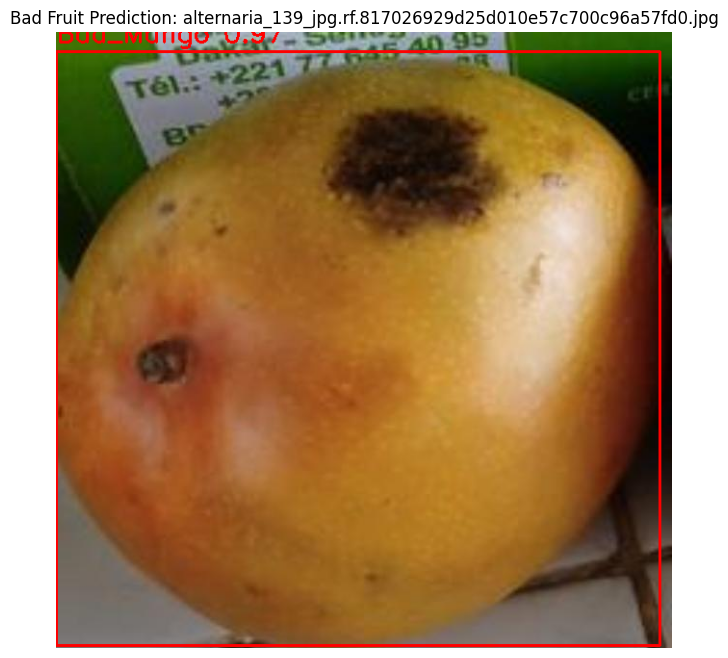


0: 640x640 1 Bad_Mango, 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


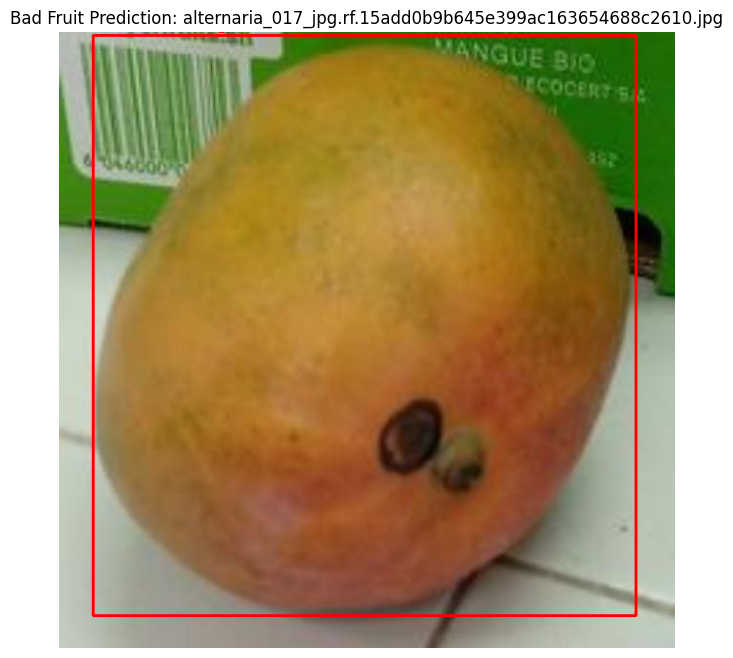


0: 640x640 1 Bad_Orange, 16.3ms
Speed: 1.5ms preprocess, 16.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


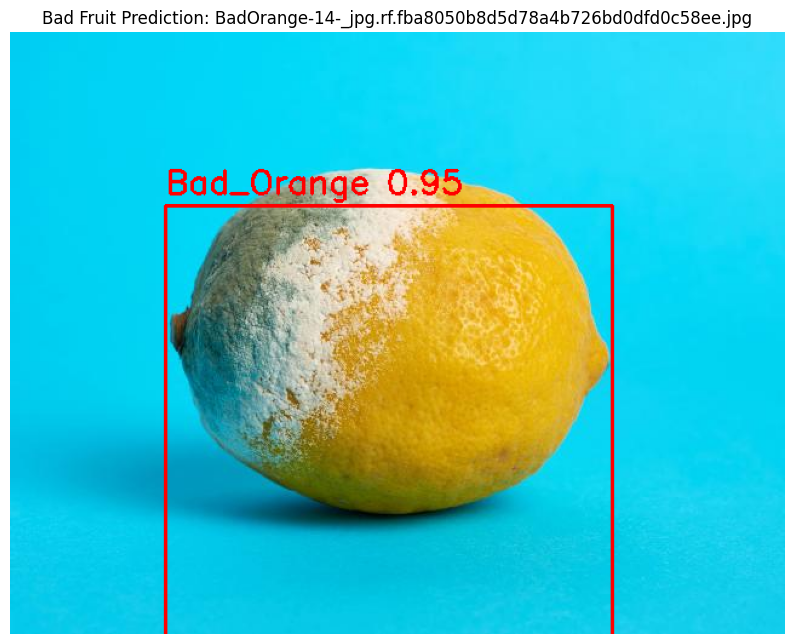

In [20]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ✅ Load model
model_path = "/kaggle/working/fruit_detection_clean/weights/best.pt"
model = YOLO(model_path)

# ✅ Define dataset paths
images_dir = "/kaggle/working/augmented_dataset/images"
labels_dir = "/kaggle/working/augmented_dataset/labels"

# ✅ Define class names and bad class IDs
class_names = [
    "Bad_Apple", "Bad_Guava", "Bad_Mango", "Bad_Orange",
    "Good_Apple", "Good_Guava", "Good_Mango", "Good_Orange"
]
bad_class_ids = [i for i, name in enumerate(class_names) if "Bad" in name]

# ✅ Get matching image-label pairs
image_files = [f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))]
num_to_show = 5
shown = 0

for img_file in image_files:
    if shown >= num_to_show:
        break

    label_file = img_file.rsplit('.', 1)[0] + ".txt"
    label_path = os.path.join(labels_dir, label_file)

    # Skip if label doesn't exist
    if not os.path.exists(label_path):
        continue

    # ✅ Check for bad class IDs
    with open(label_path, 'r') as file:
        lines = file.readlines()
        found_bad = any(int(line.split()[0]) in bad_class_ids for line in lines)

    if found_bad:
        # ✅ Load and resize image
        img_path = os.path.join(images_dir, img_file)
        image = cv2.imread(img_path)
        if image is None:
            continue
        image_resized = cv2.resize(image, (640, 640))

        # ✅ Run inference
        results = model.predict(image_resized, conf=0.25)

        # ✅ Draw bounding boxes
        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            scores = result.boxes.conf.cpu().numpy()
            class_ids = result.boxes.cls.cpu().numpy()
            for box, score, class_id in zip(boxes, scores, class_ids):
                x1, y1, x2, y2 = map(int, box)
                label = f"{class_names[int(class_id)]} {score:.2f}"
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

        # ✅ Show image
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Bad Fruit Prediction: {img_file}")
        plt.axis('off')
        plt.show()

        shown += 1
